In [96]:
import numpy as np
import pandas as pd
import pymc as pm
np.random.seed(1)
from mogp import MultiOutputMarginal

In [97]:
df = pd.read_csv("../data/economy/econ_metrics.csv")
df.shape

(201, 6)

In [98]:
df.head()

,Date,Fed Rate,unemployment,sp500,nasdaq,bitcoin
0,2006-01-01,4.29,4.7,1278.723000,2287.434033,NaN
1,2006-02-01,4.49,4.8,1276.645263,2283.470032,NaN
2,2006-03-01,4.59,4.7,1293.740000,2305.282532,NaN
3,2006-04-01,4.79,4.7,1302.183684,2332.640075,NaN
4,2006-05-01,4.94,4.6,1290.000000,2242.002002,NaN


In [99]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")

In [100]:
df.describe()

,Fed Rate,unemployment,sp500,nasdaq,bitcoin
count,200.00000,200.000000,201.000000,201.000000,97.000000
mean,1.15295,6.145000,2101.869353,5401.326350,12652.810296
std,1.61951,2.182888,987.781525,3699.380190,16323.689647
min,0.05000,3.500000,757.126818,1469.937988,229.635250
25%,0.10000,4.400000,1323.484286,2497.232483,665.767993
50%,0.19000,5.400000,1889.767143,4235.352539,6702.184936
75%,1.81250,7.900000,2705.155263,7296.144043,12408.956055
max,5.26000,14.700000,4674.772727,15693.424024,59643.747071


In [101]:
columns = ["Fed Rate","unemployment", "sp500", "nasdaq"]
df[columns] = (df[columns] - df[columns].mean()) / df[columns].std()
df = df.drop(columns="bitcoin")
df = df.dropna()
df.shape

(200, 4)

In [102]:
df.head()

,Fed Rate,unemployment,sp500,nasdaq
Date,,,,
2006-01-01,1.937036,-0.661967,-0.833328,-0.841734
2006-02-01,2.060530,-0.616156,-0.835432,-0.842805
2006-03-01,2.122277,-0.661967,-0.818126,-0.836909
2006-04-01,2.245771,-0.661967,-0.809577,-0.829514
2006-05-01,2.338392,-0.707778,-0.821912,-0.854015


In [103]:
df["x"] = range(df.shape[0])
df

,Fed Rate,unemployment,sp500,nasdaq,x
Date,,,,,
2006-01-01,1.937036,-0.661967,-0.833328,-0.841734,0
2006-02-01,2.060530,-0.616156,-0.835432,-0.842805,1
2006-03-01,2.122277,-0.661967,-0.818126,-0.836909,2
2006-04-01,2.245771,-0.661967,-0.809577,-0.829514,3
2006-05-01,2.338392,-0.707778,-0.821912,-0.854015,4
...,...,...,...,...,...
2022-04-01,-0.508147,-1.165887,2.317746,2.069989,195
2022-05-01,-0.236460,-1.165887,1.962469,1.753889,196
2022-06-01,0.035227,-1.165887,1.819306,1.572462,197


<AxesSubplot:xlabel='Date'>

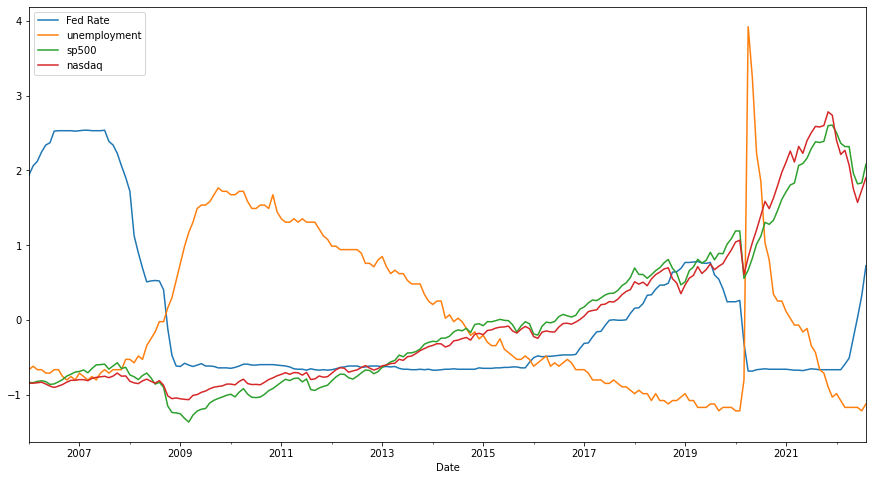

In [104]:
df[columns].plot(figsize=(15, 8))

### 1: Implement ICM (one kernel) by using pm.gp.cov.Kron

$$
K = K_1(x, x') \otimes K_2(o, o')
$$

In [105]:
df.columns

Index(['Fed Rate', 'unemployment', 'sp500', 'nasdaq', 'x'], dtype='object')

In [112]:
columns = ["Fed Rate", "sp500", "nasdaq"]
x = df['x'].values.reshape(-1,1)
y = df[columns].values.reshape(-1,1)
task_i = np.linspace(0, 2, 3)[:, None]
X = pm.math.cartesian(x, task_i)
x.shape, task_i.shape, X.shape

((200, 1), (3, 1), (600, 2))

In [113]:
X.shape, y.shape

((600, 2), (600, 1))

In [114]:
import aesara.tensor as at
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
    
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    B = pm.Deterministic('B', at.dot(W, W.T) + at.diag(kappa))
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    mogp = MultiOutputMarginal(means=0, kernels=[cov], num_outputs=3, same_input=True, input_dim=1, B=B)
    y_ = mogp.marginal_likelihood("f", X, y.squeeze(), noise=sigma)

In [ ]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma]


#### Prediction

In [ ]:
x_new = np.linspace(0, 200, M)[:, None]

In [14]:
Xnew.shape

(240, 2)

In [15]:
%%time
with model:
    preds = mogp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

CPU times: user 24 s, sys: 25.4 s, total: 49.4 s
Wall time: 7.49 s


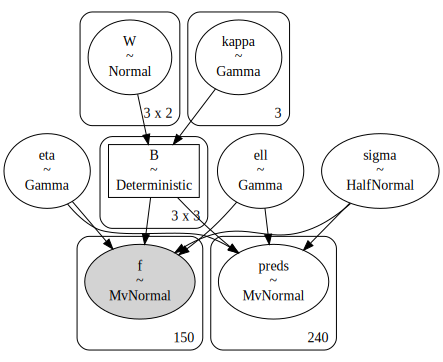

In [16]:
pm.model_to_graphviz(model)

In [17]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 240)

#### Plot the GP prediction

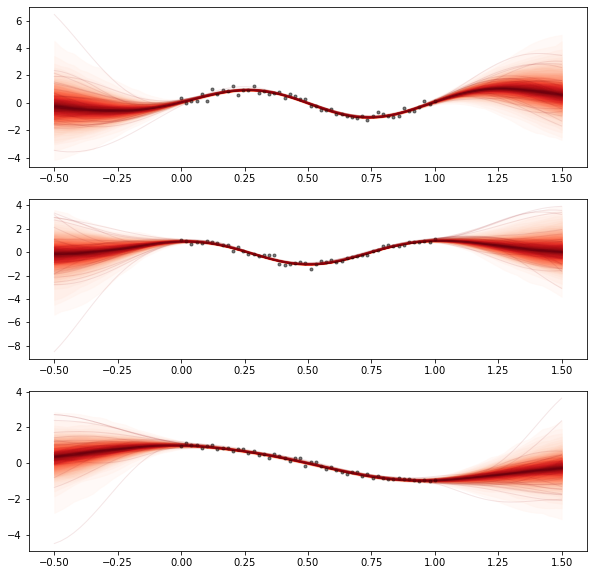

In [18]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label=f"Data {idx}");
    plot_gp_dist(axes[idx], f_pred[:,Xnew[:,1] == idx], xnew,
                 fill_alpha=0.5, samples_alpha=0.1)

plt.show()

In [19]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",0.043,2.104,-3.894,3.928,0.131,0.095,269.0,280.0,NaN
"W[0, 1]",-0.087,2.237,-4.519,3.880,0.148,0.105,227.0,292.0,NaN
"W[1, 0]",-0.050,2.171,-4.141,3.800,0.129,0.091,284.0,375.0,NaN
"W[1, 1]",0.349,2.095,-3.328,4.393,0.127,0.091,271.0,314.0,NaN
"W[2, 0]",-0.013,1.059,-2.052,1.763,0.065,0.046,292.0,293.0,NaN
"W[2, 1]",-0.074,1.019,-1.923,2.055,0.050,0.057,417.0,258.0,NaN
ell,0.333,0.044,0.249,0.408,0.002,0.002,401.0,375.0,NaN
eta,0.664,0.253,0.276,1.126,0.015,0.010,279.0,338.0,NaN
kappa[0],1.789,1.309,0.054,3.992,0.062,0.044,325.0,204.0,NaN
kappa[1],1.729,1.385,0.012,4.300,0.071,0.050,249.0,154.0,NaN


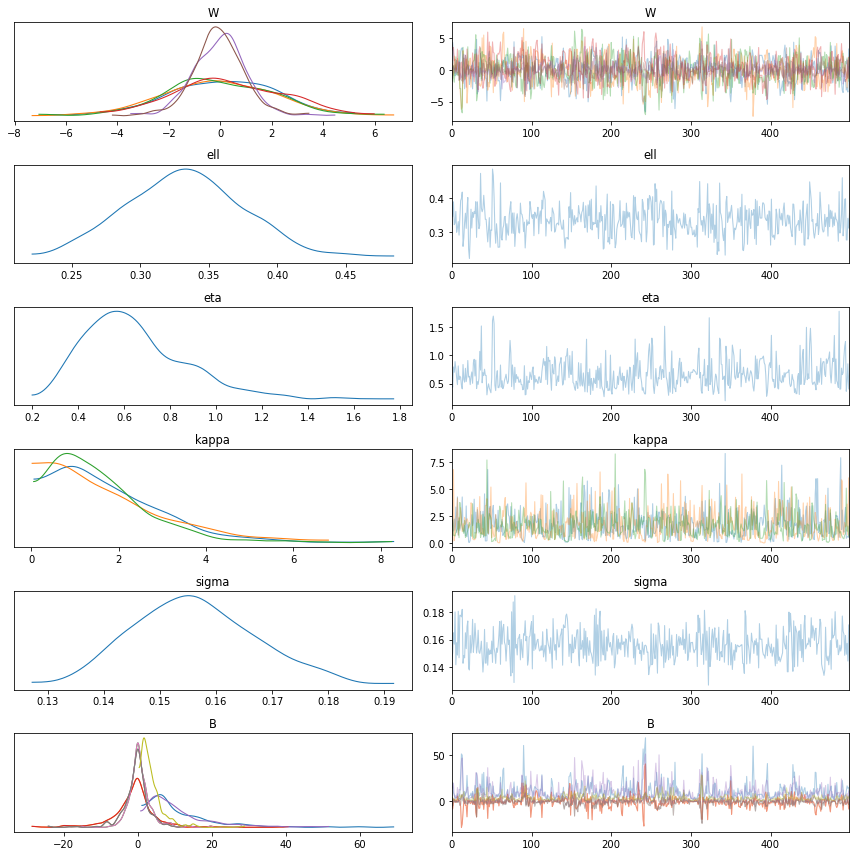

In [20]:
az.plot_trace(gp_trace);
plt.tight_layout()